# Logistic Regression for Sentiment Analysis

Adapted from http://nbviewer.jupyter.org/github/rasbt/pattern_classification/blob/master/machine_learning/scikit-learn/outofcore_modelpersistence.ipynb

<br>
<br>

## The IMDb Movie Review Dataset

In this section, we will train a simple logistic regression model to classify movie reviews from the 50k IMDb review dataset that has been collected by Maas et. al.

> AL Maas, RE Daly, PT Pham, D Huang, AY Ng, and C Potts. Learning word vectors for sentiment analysis. In Proceedings of the 49th Annual Meeting of the Association for Computational Lin- guistics: Human Language Technologies, pages 142–150, Portland, Oregon, USA, June 2011. Association for Computational Linguistics

[Source: http://ai.stanford.edu/~amaas/data/sentiment/]

The dataset consists of 50,000 movie reviews from the original "train" and "test" subdirectories. The class labels are binary (1=positive and 0=negative) and contain 25,000 positive and 25,000 negative movie reviews, respectively.
For simplicity, I assembled the reviews in a single CSV file.


In [1]:
import pandas as pd
# if you want to download the original file:
#df = pd.read_csv('https://raw.githubusercontent.com/rasbt/pattern_classification/master/data/50k_imdb_movie_reviews.csv')
# otherwise load local file
df = pd.read_csv('shuffled_movie_data.csv')
df.tail()

,review,sentiment
49995,"OK, lets start with the best. the building. al...",0
49996,The British 'heritage film' industry is out of...,0
49997,I don't even know where to begin on this one. ...,0
49998,Richard Tyler is a little boy who is scared of...,0
49999,I waited long to watch this movie. Also becaus...,1


Let us shuffle the class labels.

In [2]:
import numpy as np
## uncomment these lines if you have dowloaded the original file:
#np.random.seed(0)
#df = df.reindex(np.random.permutation(df.index))
#df[['review', 'sentiment']].to_csv('shuffled_movie_data.csv', index=False)

<br>
<br>

## Preprocessing Text Data

Now, let us define a simple `tokenizer` that splits the text into individual word tokens. Furthermore, we will use some simple regular expression to remove HTML markup and all non-letter characters but "emoticons," convert the text to lower case, remove stopwords, and apply the Porter stemming algorithm to convert the words into their root form.

In [3]:
import numpy as np
from nltk.stem.porter import PorterStemmer
import re
from nltk.corpus import stopwords

stop = stopwords.words('english')
porter = PorterStemmer()

def tokenizer(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text.lower())
    text = re.sub('[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-', '')
    text = [w for w in text.split() if w not in stop]
    tokenized = [porter.stem(w) for w in text]
    return text
    #return tokenized

Let's give it at try:

In [4]:
tokenizer('This :) is a <a> test! :-)</br>')

['test', ':)', ':)']

## Learning (SciKit)

First, we define a generator that returns the document body and the corresponding class label:

In [5]:
def stream_docs(path):
    with open(path, 'r') as csv:
        next(csv) # skip header
        for line in csv:
            text, label = line[:-3], int(line[-2])
            yield text, label

To conform that the `stream_docs` function fetches the documents as intended, let us execute the following code snippet before we implement the `get_minibatch` function:

In [6]:
a = next(stream_docs(path='shuffled_movie_data.csv'))
print(a)
#print(tokenizer(a[0]))

('"In 1974, the teenager Martha Moxley (Maggie Grace) moves to the high-class area of Belle Haven, Greenwich, Connecticut. On the Mischief Night, eve of Halloween, she was murdered in the backyard of her house and her murder remained unsolved. Twenty-two years later, the writer Mark Fuhrman (Christopher Meloni), who is a former LA detective that has fallen in disgrace for perjury in O.J. Simpson trial and moved to Idaho, decides to investigate the case with his partner Stephen Weeks (Andrew Mitchell) with the purpose of writing a book. The locals squirm and do not welcome them, but with the support of the retired detective Steve Carroll (Robert Forster) that was in charge of the investigation in the 70\'s, they discover the criminal and a net of power and money to cover the murder.<br /><br />""Murder in Greenwich"" is a good TV movie, with the true story of a murder of a fifteen years old girl that was committed by a wealthy teenager whose mother was a Kennedy. The powerful and rich f

After we confirmed that our `stream_docs` functions works, we will now implement a `get_minibatch` function to fetch a specified number (`size`) of documents:

In [7]:
def get_minibatch(doc_stream, size):
    docs, y = [], []
    for _ in range(size):
        text, label = next(doc_stream)
        docs.append(text)
        y.append(label)
    return docs, y

Next, we will make use of the "hashing trick" through scikit-learns [HashingVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.HashingVectorizer.html) to create a bag-of-words model of our documents. Details of the bag-of-words model for document classification can be found at  [Naive Bayes and Text Classification I - Introduction and Theory](http://arxiv.org/abs/1410.5329).

In [8]:
from sklearn.feature_extraction.text import HashingVectorizer
vect = HashingVectorizer(decode_error='ignore', 
                         n_features=2**21,
                         preprocessor=None, 
                         tokenizer=tokenizer)

# Exercise 1: define features based on word embeddings (pre-trained word2vec vectors can be used)
# Define suitable d dimension, and sequence length

Using the [SGDClassifier]() from scikit-learn, we will can instanciate a logistic regression classifier that learns from the documents incrementally using stochastic gradient descent. 

In [9]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(loss='log', random_state=1, max_iter=1)
doc_stream = stream_docs(path='shuffled_movie_data.csv')
# Exercise 2: Define at least a Three layer neural network. Define its structure (number of hidden neurons, etc)
# Define nonlinear function for hidden layers.
# Define a suitbale loss function for binary classification
# Implement the backpropagation algorithm for this structure
# Train the model using SGD

In [10]:
#import pyprind
#pbar = pyprind.ProgBar(45)

classes = np.array([0, 1])
for _ in range(45):
    X_train, y_train = get_minibatch(doc_stream, size=1000)
    X_train = vect.transform(X_train)
    clf.partial_fit(X_train, y_train, classes=classes)
    #pbar.update()

Depending on your machine, it will take about 2-3 minutes to stream the documents and learn the weights for the logistic regression model to classify "new" movie reviews. Executing the preceding code, we used the first 45,000 movie reviews to train the classifier, which means that we have 5,000 reviews left for testing:

In [11]:
X_test, y_test = get_minibatch(doc_stream, size=5000)
X_test = vect.transform(X_test)
acc_sky_hash = clf.score(X_test, y_test)
print('Accuracy: %.3f' % acc_sky_hash)
#Exercise 3: compare  with your Neural Network

Accuracy: 0.867


I think that the predictive performance, an accuracy of ~87%, is quite "reasonable" given that we "only" used the default parameters and didn't do any hyperparameter optimization. 

After we estimated the model perfomance, let us use those last 5,000 test samples to update our model.

In [12]:
clf = clf.partial_fit(X_test, y_test)

## EJERCICIO 1

In [82]:
def tokenizer2(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text.lower())
    text = re.sub('[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-', '')
    text = [w for w in text.split() if w not in stop]
    tokenized = [porter.stem(w) for w in text]
    return tokenized

## EJERCICIO 2

EN doc2vect.ipynb entrenamos los pesos para poder convertir cada review en un vector de 300 features.
Las caracteristicas de cada vector sera de 300.

Primero leeremos los reviews y luego convertiremos a su respectivo vector, luego usaremos un clasificador
de skylearn (MODELO SKY) para ver si el doc2vect esta funcionando correctamente.

Por ultimo definiremos un red neuronal (MODELO NN) par la cual se implementara el backpropagation y el entramiento sera SGD

## Cargamos el modelo doc2vect

In [83]:
# el modelo debe estar guardado en la carpeta de trabajo, si no esta se puede generar ejecutando doc2vect.ipynb
from random import shuffle
# gensim modules
from gensim import utils
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec

model = Doc2Vec.load('./model.d2v')

## Modelo SKY

In [84]:
# CLASSIFIER DE SKYLEARN EL CUAL USARA LOS VECTORES FORMADOS POR Doc2Vect

prefix = 'REVIEW'
doc_stream = stream_docs(path='shuffled_movie_data.csv')
data_reviews, data_labels = get_minibatch(doc_stream, 45000)

train_arrays = np.zeros((45000, 300))
train_labels = np.zeros(45000)

# leemos cada review y calculamos su respectivo vector con 300 caracteristicas
# for training
for i in range(45000):
    train_arrays[i] = model.docvecs[prefix + '_%s' % i]
    train_labels[i] = data_labels[i]

# for test
data_reviews, data_labels = get_minibatch(doc_stream, 5000)
test_arrays = np.zeros((5000, 300))
test_labels = np.zeros(5000)

# for training
for i in range(5000):
    test_arrays[i] = model.docvecs[prefix + '_%s' % (i+45000)]
    test_labels[i] = data_labels[i]

In [18]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
classifier.fit(train_arrays, train_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [19]:
# verificamos tanto en el trainning como en el test, para ver que no haya overfitting
acc_sky_doc2vect = classifier.score(test_arrays, test_labels)
print('Accuracy training: %.3f' % classifier.score(train_arrays, train_labels))
print('Accuracy test: %.3f' % acc_sky_doc2vect)

Accuracy training: 0.876
Accuracy test: 0.869


## Modelo NN

In [86]:
# Es nuestro implementacion de red neuronal y como datos de entrenamiento usara los vectores de doc2vect

# ya tenemos los datos de entrenamiento y test, convertimos de array a dataframe para la NN
import pandas as pd
train_arrays = pd.DataFrame(data=train_arrays)
test_arrays = pd.DataFrame(data=test_arrays)

train_labels = np.reshape(train_labels,(train_labels.shape[0],1))
test_labels = np.reshape(test_labels, (test_labels.shape[0],1))


In [97]:
# en esta clase definimos la estructura de la NN
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes
        self.lr = learning_rate
        self.l2_m = 0
        self.l1_m = 0
        self.l2_v = 0
        self.l1_v = 0
        self.t = 0
        
        # inicializacion weights
        self.w0 = np.random.normal(0.0, 0.1, (self.input_nodes, self.hidden_nodes))
        self.w1 = np.random.normal(0.0, 0.1, (self.hidden_nodes, self.output_nodes))
        
        def sigmoid(x, deriv=False):
            if deriv:
                return x*(1-x)
            return 1/(1+np.exp(-x))
        
        self.activation_function = sigmoid
        
    def train(self, features, targets):
        # Feed Forward
        l0 = features
        l1 = self.activation_function(np.dot(l0, self.w0))
        l2 = self.activation_function(np.dot(l1, self.w1))
        
        # Backpropagation
        l2_error = l2 - targets
        l2_delta = l2_error * self.activation_function(l2, deriv=True)
        l1_error = l2_delta.dot(self.w1.T)
        l1_delta = l1_error * self.activation_function(l1, deriv=True)
        
        # Actualizar weights
        self.w1 -= self.lr * l1.T.dot(l2_delta)
        self.w0 -= self.lr * l0.T.dot(l1_delta)
            
    def run(self, features):
        l0 = features
        l1 = self.activation_function(np.dot(l0, self.w0))
        l2 = self.activation_function(np.dot(l1, self.w1))
        return l2
    def compute_accuracy_test(self):
        test_predictions = self.run(test_arrays)
        total = 0
        correct = 0
        for i in range(len(test_predictions)):
            total += 1
            if test_predictions[i] < 0.5 and test_labels[i] == 0:
                correct += 1
            elif test_predictions[i] >= 0.5 and test_labels[i] == 1:
                correct += 1
        return float(correct)/float(total)
    
    def compute_accuracy_train(self):
        train_predictions = self.run(train_arrays)
        total = 0
        correct = 0
        for i in range(len(train_predictions)):
            total += 1
            if train_predictions[i] < 0.5 and train_labels[i] == 0:
                correct += 1
            elif train_predictions[i] >= 0.5 and train_labels[i] == 1:
                correct += 1
        return float(correct)/float(total)
    
def MSE(y, Y):
    return np.mean((y-Y)**2)


# Con esta funcion administramos como sera el entrenamiento
# como es SGD entonces entramos por batch
def build_train_NN(network, epochs, batch_size):
    losses = {'train':[], 'validation':[]} 

    train_loss = 0
    val_loss = 0
        
    # Iterating Over Epochs
    for i in range(epochs):    
        for k in range(train_arrays.shape[0]// batch_size):
            batch = np.random.choice(train_arrays.index, size=batch_size)
            X, y = train_arrays.ix[batch].values, train_labels[batch]

            network.train(X, y)

            train_loss = MSE(network.run(train_arrays), train_labels)
            val_loss = MSE(network.run(test_arrays), test_labels)
        
        print('Epoch {}, Train Loss: {}, Val Loss: {}'.format(i, train_loss, val_loss))
        losses['train'].append(train_loss)
        losses['validation'].append(val_loss)
        
    return losses

In [98]:
import matplotlib.pyplot as plt

epochs = 5
learning_rate = 0.01
hidden_nodes = 10
output_nodes = 1
batch_size = 64

nn = NeuralNetwork(train_arrays.shape[1], hidden_nodes, output_nodes, learning_rate)
losses = build_train_NN(nn, epochs, batch_size)

Epoch 0, Train Loss: 0.0935933508897, Val Loss: 0.0962742330314
Epoch 1, Train Loss: 0.0926962642341, Val Loss: 0.0988912934842
Epoch 2, Train Loss: 0.0898798658821, Val Loss: 0.0974372254184
Epoch 3, Train Loss: 0.0892614131068, Val Loss: 0.0976722328502
Epoch 4, Train Loss: 0.0879803838688, Val Loss: 0.0961338839662


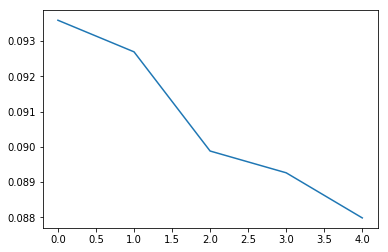

In [99]:
%matplotlib inline
plt.plot(losses['train'], label='Loss training')
#plt.plot(losses['validation'], label='Loss validacion')

In [100]:
# comprobemos que no hay overfitting
acc_nn_doc2vect = nn.compute_accuracy_test()
print('Accuracy training NN: %.3f' % nn.compute_accuracy_train())
print('Accuracy test NN: %.3f' % acc_nn_doc2vect)

Accuracy training NN: 0.882
Accuracy test NN: 0.872


## EJERCICIO 3

compararemos los modelos:

Tenemos modelo sky con hashing vector(modelo original), modelo sky con doc2vect, y modelo NN con doc2vect

In [101]:
print('Accuracy SKY hash (original): %.3f' % acc_sky_hash)
print('Accuracy SKY con doc2vect   : %.3f' % acc_sky_doc2vect)
print('Accuracy NN con doc2vect    : %.3f' % acc_nn_doc2vect)

Accuracy SKY hash (original): 0.867
Accuracy SKY con doc2vect   : 0.869
Accuracy NN con doc2vect    : 0.872


In [102]:
# probando el modelo NN con un review
example = ['I like this movie']
s_array = np.zeros((1, 300))
s_array[0] = model.infer_vector(tokenizer(example[0]))
s = pd.DataFrame(data=s_array)
pred = nn.run(s)
round(pred)

1.0

<br>
<br>

# Model Persistence

In the previous section, we successfully trained a model to predict the sentiment of a movie review. Unfortunately, if we'd close this IPython notebook at this point, we'd have to go through the whole learning process again and again if we'd want to make a prediction on "new data."

So, to reuse this model, we could use the [`pickle`](https://docs.python.org/3.5/library/pickle.html) module to "serialize a Python object structure". Or even better, we could use the [`joblib`](https://pypi.python.org/pypi/joblib) library, which handles large NumPy arrays more efficiently.

To install:
conda install -c anaconda joblib

In [21]:
import joblib
import os
if not os.path.exists('./pkl_objects'):
    os.mkdir('./pkl_objects')
    
joblib.dump(vect, './vectorizer.pkl')
joblib.dump(clf, './clf.pkl')

['./clf.pkl']

Using the code above, we "pickled" the `HashingVectorizer` and the `SGDClassifier` so that we can re-use those objects later. However, `pickle` and `joblib` have a known issue with `pickling` objects or functions from a `__main__` block and we'd get an `AttributeError: Can't get attribute [x] on <module '__main__'>` if we'd unpickle it later. Thus, to pickle the `tokenizer` function, we can write it to a file and import it to get the `namespace` "right".

In [22]:
%%writefile tokenizer.py
from nltk.stem.porter import PorterStemmer
import re
from nltk.corpus import stopwords

stop = stopwords.words('english')
porter = PorterStemmer()

def tokenizer(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text.lower())
    text = re.sub('[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-', '')
    text = [w for w in text.split() if w not in stop]
    tokenized = [porter.stem(w) for w in text]
    return text

Writing tokenizer.py


In [23]:
from tokenizer import tokenizer
joblib.dump(tokenizer, './tokenizer.pkl')

['./tokenizer.pkl']

Now, let us restart this IPython notebook and check if the we can load our serialized objects:

In [24]:
import joblib
tokenizer = joblib.load('./tokenizer.pkl')
vect = joblib.load('./vectorizer.pkl')
clf = joblib.load('./clf.pkl')

After loading the `tokenizer`, `HashingVectorizer`, and the tranined logistic regression model, we can use it to make predictions on new data, which can be useful, for example, if we'd want to embed our classifier into a web application -- a topic for another IPython notebook.

In [25]:
example = ['I did not like this movie']
X = vect.transform(example)
clf.predict(X)

array([0])

In [26]:
example = ['I loved this movie']
X = vect.transform(example)
clf.predict(X)

array([1])